In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor
import pymannkendall as mk

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/home/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [2]:
# a hack from stackoverflow to normalize the colorbar and set arbitrary midpoint locations
# while maintaining the colorbar's linearity
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
# # read nothern hemisphere winter temperature data from raw nc files
# months = [1, 2, 3, 11, 12]
# years = np.arange(1980, 2020, 10)
# data = []
# for yy in years:
#     file_ = path_ + pre_ + str(yy) + '.nc'
#     with xr.open_dataset(file_) as ds:
#         pause = 1
#         t1 = time()
#         for dy in range(10):
#             for mm in months:
#                 if mm == 2:
#                     filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm) & (ds.day != 29), drop=True)
#                 else:
#                     filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm), drop=True)
#                 data.append(filter_ds.temperature)
#         print('Time taken for year ', yy, ' is ', time() - t1)

# concatenated_data = xr.concat(data, dim='time')
# temp = concatenated_data.values

# # recover the original values by adding the climatology
# with xr.open_dataset(path_ + pre_ + '1980.nc') as ds:
#     climatology = ds.climatology.values[:,-90:,:]

# # day-of-year mask for Jan-Feb-Mar-Nov-Dec
# doy_l = [0, 31, 59, 304, 334]
# doy_r = [31, 59, 90, 334, 365]
# # day-of-season mask for Jan-Feb-Mar-Nov-Dec
# ll = [0, 31, 59, 90, 120, 151]
# for yy in range(40):
#     t1 = time()
#     for mm in range(5):
#         il, ir = 151*yy + ll[mm], 151*yy + ll[mm+1]
#         temp[il:ir,:,:] += climatology[doy_l[mm]:doy_r[mm],:,:]
#     print('Time taken for year ', yy, ' is ', time() - t1)

# output = open('NH_winter_temp.pkl', 'wb')
# pickle.dump(temp, output)
# output.close()


In [3]:
# read processed data from pkl file
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

mask = 1 - np.isnan(np.mean(temp_mean, axis=0))
# the 1-deg mask is downscaled from the 2-deg from Gottlieb 2024 et al.
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [4]:
# compute median and mean trends
# i followed Gottlieb 2024 to use a Theil-Sen estimator for trends 
# and i used the mann kendal test for the trend significance 
# according to this post https://stats.stackexchange.com/questions/646424/how-to-test-significance-of-theil-sen-estimate
# the significance test should be 'compatible' with the estimator

k_mean = np.zeros((90, 360))
k_median = np.zeros((90, 360))
pv_mean = np.zeros((90, 360))
pv_median = np.zeros((90, 360))

diff_v = []
k_median_v = []

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])
        k_mean[i,j] = lm1.coef_[0] * 10
        mk_res1 = mk.original_test(temp_mean[:,i,j])
        pv_mean[i,j] = mk_res1.p

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        k_median[i,j] = lm2.coef_[0] * 10
        mk_res2 = mk.original_test(temp_median[:,i,j])
        pv_median[i,j] = mk_res2.p
        
        diff_v.append(k_median[i,j] - k_mean[i,j])
        k_median_v.append(k_median[i,j])

diff_v = np.array(diff_v)
k_median_v = np.array(k_median_v)

Processing  1000  grids. Time taken so far:  21.518433809280396
Processing  2000  grids. Time taken so far:  43.8687801361084
Processing  3000  grids. Time taken so far:  66.38835668563843
Processing  4000  grids. Time taken so far:  88.95156693458557
Processing  5000  grids. Time taken so far:  112.39865684509277
Processing  6000  grids. Time taken so far:  136.59618377685547
Processing  7000  grids. Time taken so far:  161.395672082901


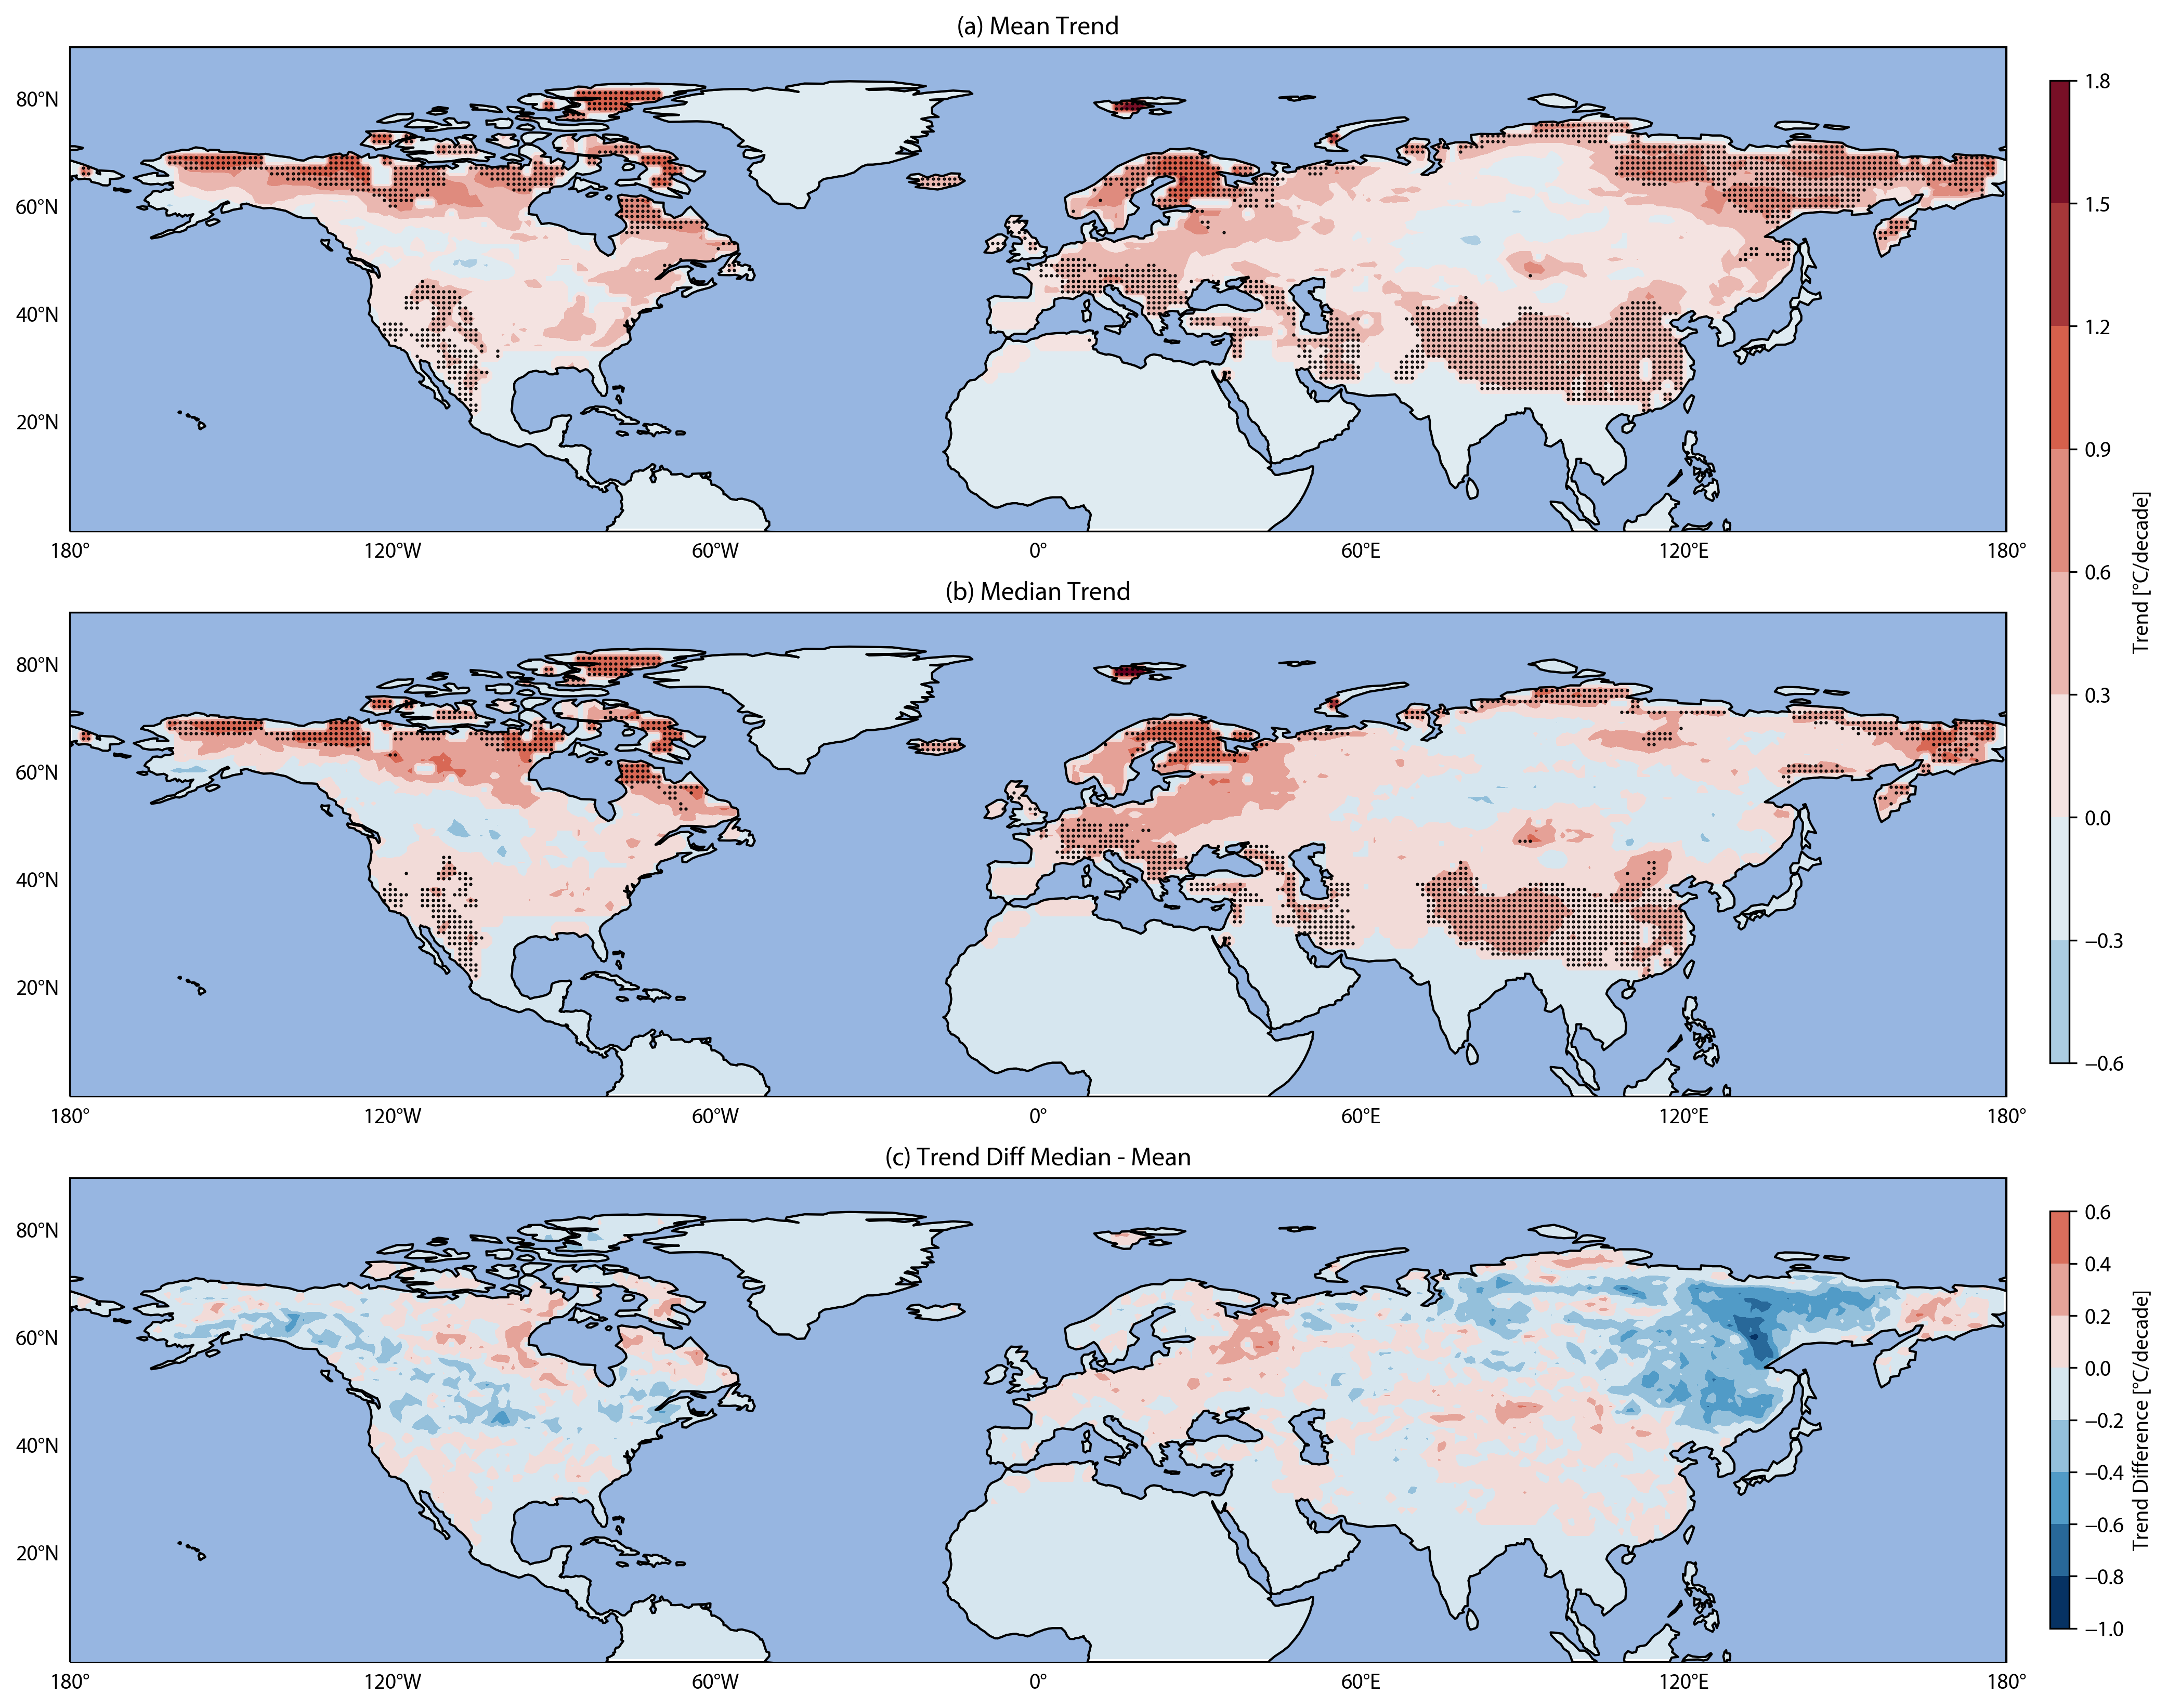

In [5]:
# plot median and mean trends
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv_mean[mask == 0] = 1
pv_median[mask == 0] = 1

trend_max = np.max([np.max(k_mean), np.max(k_median)])
trend_min = np.min([np.min(k_mean), np.min(k_median)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 21, reverse = False)

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Mean Trend')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k_mean, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons_mean = lons[pv_mean <= 0.05]
lats_mean = lats[pv_mean <= 0.05]
ax0.scatter(lons_mean, lats_mean, color='black', marker='.', s=1, transform=ccrs.PlateCarree())

# Median Trend plot
ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Median Trend')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, k_median, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons_median = lons[pv_median <= 0.05]
lats_median = lats[pv_median <= 0.05]
ax1.scatter(lons_median, lats_median, color='black', marker='.', s=1)

# Trend Diff plot
ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend Diff Median - Mean')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
diff_min = np.min(k_median - k_mean)
diff_max = np.max(k_median - k_mean)
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
basemap2 = ax2.contourf(lon, lat, k_median - k_mean, vmin=diff_min, vmax=diff_max, cmap=cmap, norm=diff_norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

# Shared colorbar for the first two plots
cbar_ax = fig.add_subplot(gs[1:19, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

# Independent colorbar for the third plot
cbar_ax2 = fig.add_subplot(gs[21:29, 1])
cbar2 = plt.colorbar(basemap2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Trend Difference [°C/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()
fig.savefig('figures_new/mean_vs_median_trend.png')

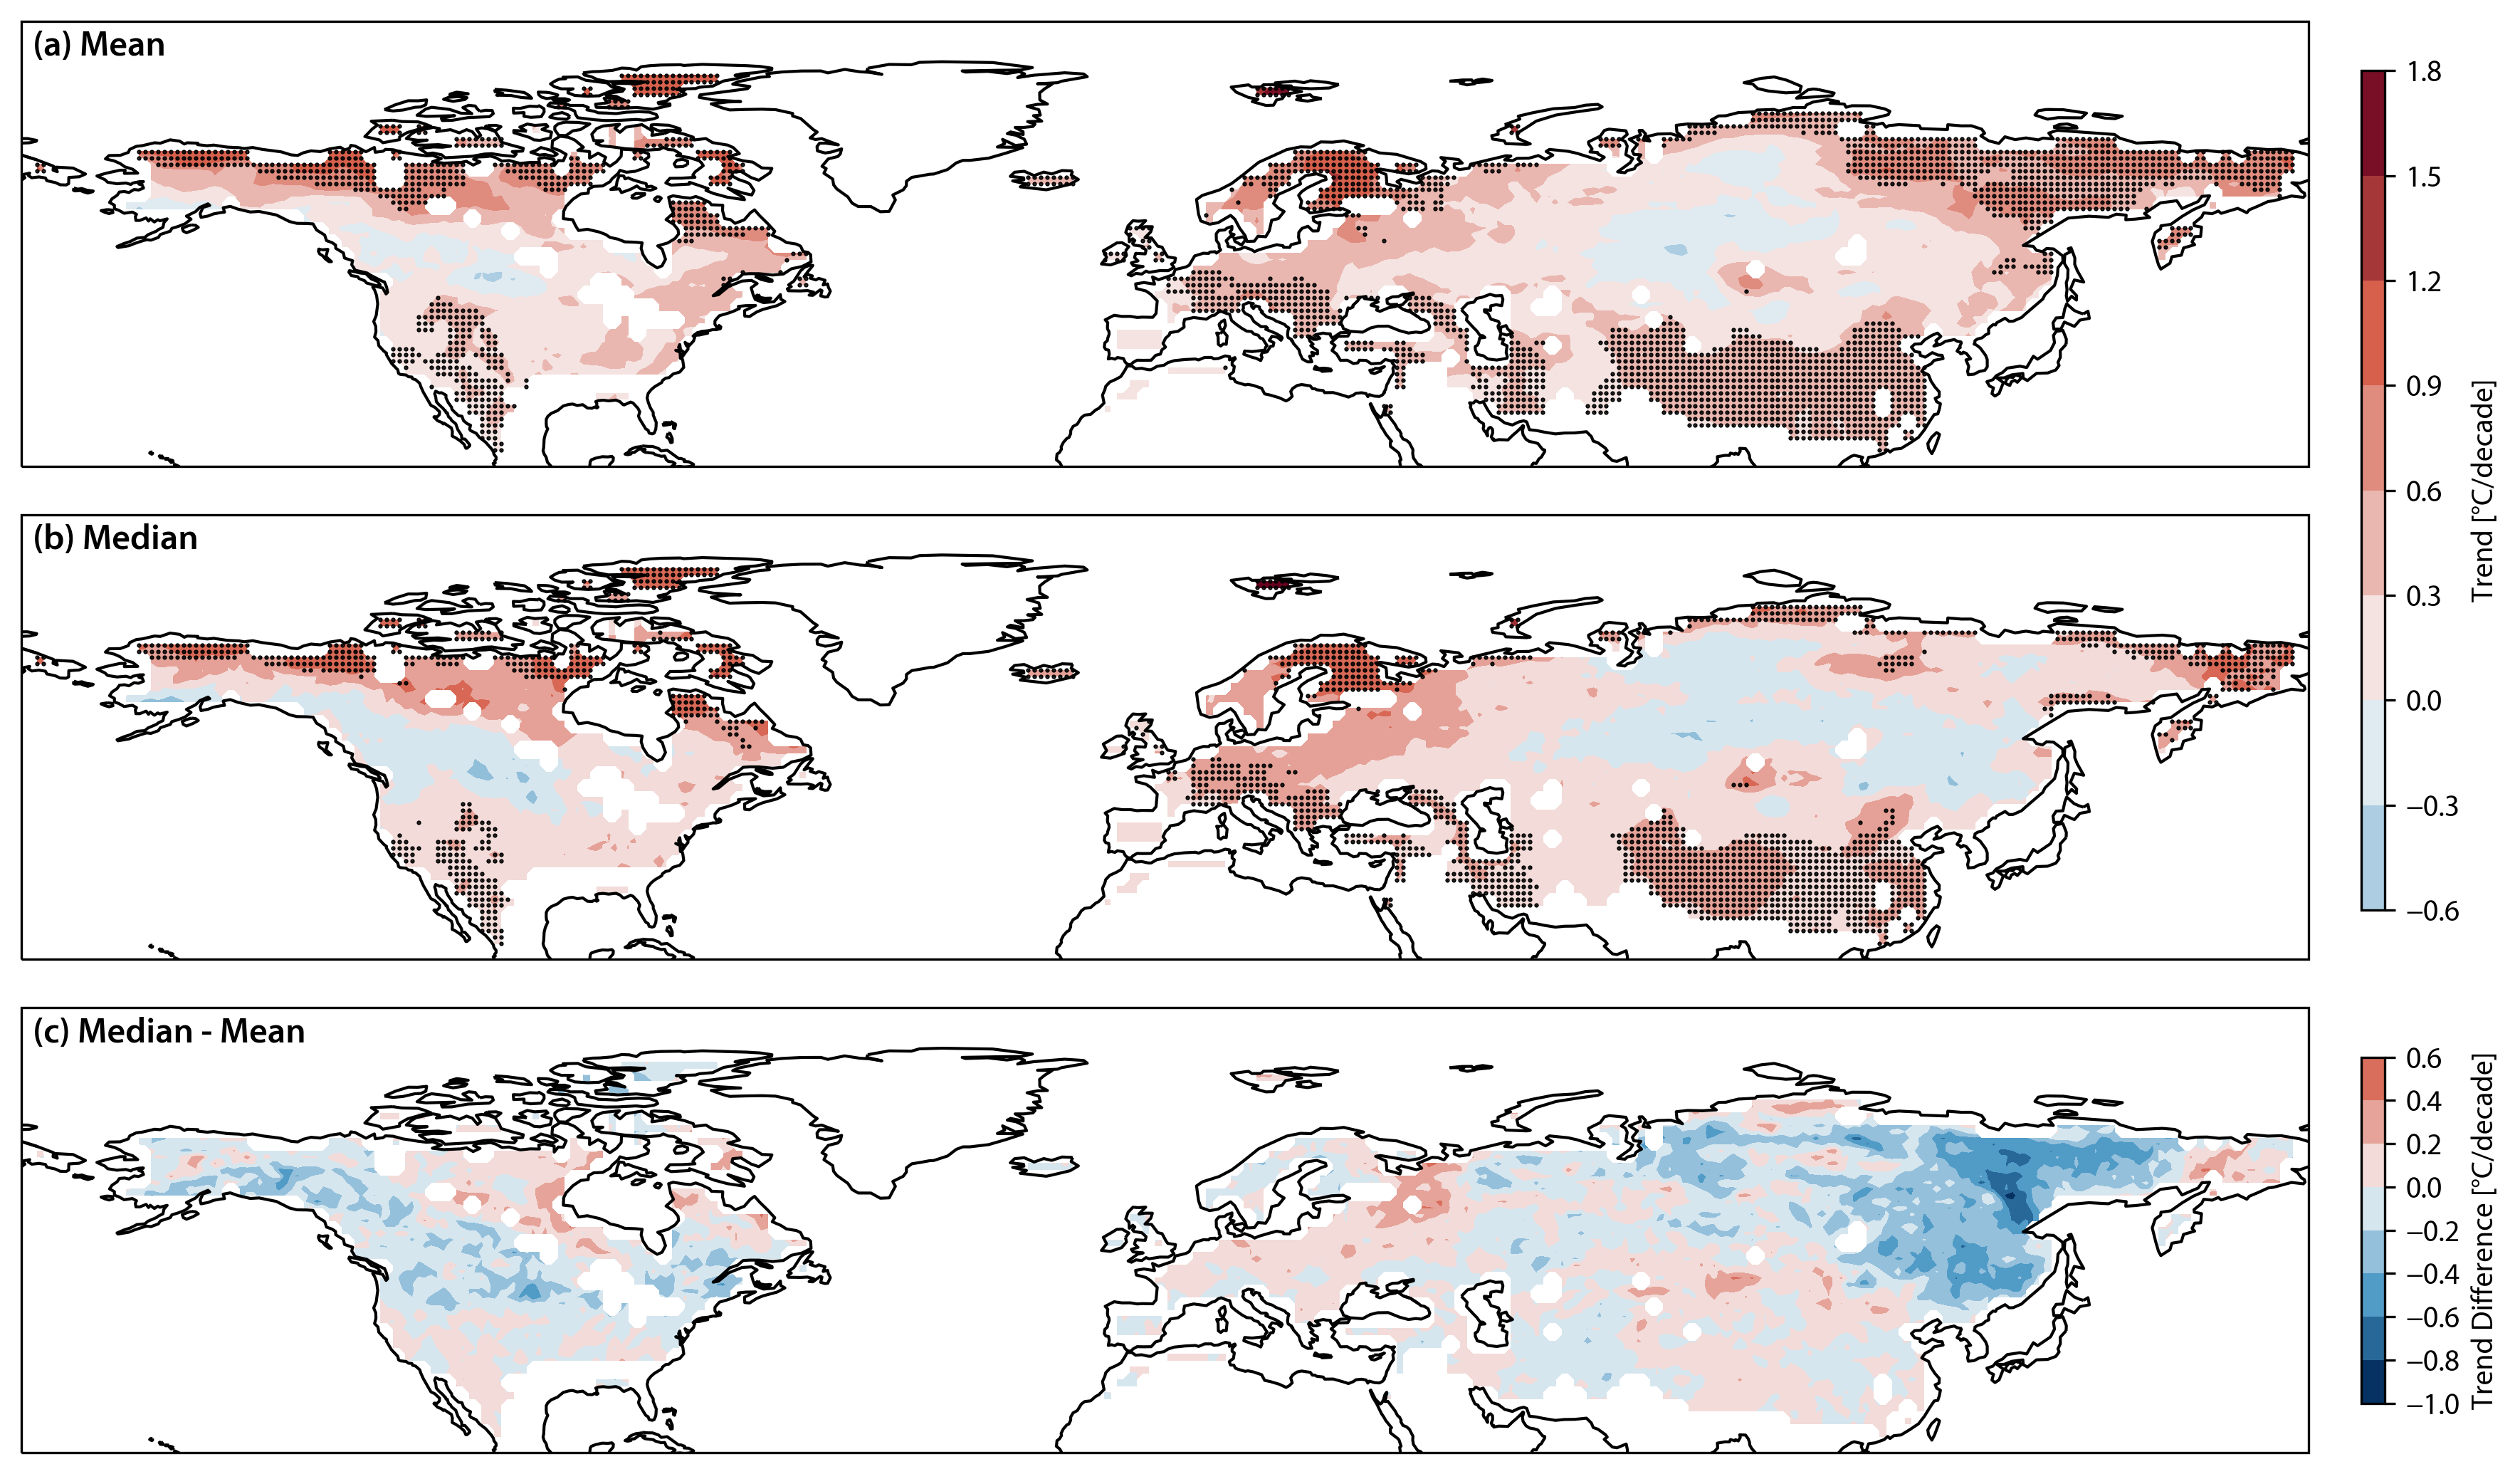

In [48]:
# praise claude for this new plotting script
# Function to set common properties for each subplot
def setup_subplot(ax, title, k_data, norm_data, base_cmap):
    ax.coastlines(color='black')
    
    # Turn off gridlines and labels
#     ax.gridlines(draw_labels=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add title inside the plot
    ax.text(0.005, 0.98, title, transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    return ax.contourf(lon, lat, k_data, vmin=norm_data.vmin, 
                      vmax=norm_data.vmax, cmap=base_cmap, 
                      norm=norm_data, transform=ccrs.PlateCarree())

# plot median and mean trends
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)

# Create masked arrays for the data
k_mean_masked = np.ma.masked_where(mask == 0, k_mean)
k_median_masked = np.ma.masked_where(mask == 0, k_median)

trend_max = np.max([np.max(k_mean), np.max(k_median)])
trend_min = np.min([np.min(k_mean), np.min(k_median)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 21, reverse = False)
# Add white color for masked values
cmap.set_bad('white')

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
basemap0 = setup_subplot(ax0, '(a) Mean', k_mean_masked, norm, cmap)
ax0.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
lons_mean = lons[pv_mean <= 0.05]
lats_mean = lats[pv_mean <= 0.05]
ax0.scatter(lons_mean, lats_mean, color='black', marker='.', s=1, transform=ccrs.PlateCarree())

# Median Trend plot
ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
basemap1 = setup_subplot(ax1, '(b) Median', k_median_masked, norm, cmap)
ax1.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
lons_median = lons[pv_median <= 0.05]
lats_median = lats[pv_median <= 0.05]
ax1.scatter(lons_median, lats_median, color='black', marker='.', s=1)

# Trend Diff plot
ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
diff_min = np.min(k_median - k_mean)
diff_max = np.max(k_median - k_mean)
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
diff_masked = np.ma.masked_where(mask == 0, k_median - k_mean)
basemap2 = setup_subplot(ax2, '(c) Median - Mean', 
                        diff_masked, diff_norm, cmap)
ax2.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

# Shared colorbar for the first two plots
cbar_ax = fig.add_subplot(gs[1:19, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

# Independent colorbar for the third plot
cbar_ax2 = fig.add_subplot(gs[21:29, 1])
cbar2 = plt.colorbar(basemap2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Trend Difference [°C/decade]')

fig.tight_layout()
plt.show()
fig.savefig('figures_new/mean_vs_median_trend_new.png')

In [ ]:
# compute days below some thresholds
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

# thre = 0
days_below_0 = np.zeros((39, 90, 360))
days_below_1 = np.zeros((39, 90, 360))
days_below_2 = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    cnt0 = np.sum((temp[left:right, :, :] < 0), axis=0)
    cnt1 = np.sum((temp[left:right, :, :] < -8), axis=0)
    cnt2 = np.sum((temp[left:right, :, :] < -15), axis=0)
    days_below_0[yy, :, :] = cnt0
    days_below_1[yy, :, :] = cnt1
    days_below_2[yy, :, :] = cnt2

In [ ]:
# compute trends of days below thresholds and p-values
k0 = np.zeros((90, 360))
k1 = np.zeros((90, 360))
k2 = np.zeros((90, 360))
pv0 = np.zeros((90, 360))
pv1 = np.zeros((90, 360))
pv2 = np.zeros((90, 360))

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm0 = TheilSenRegressor(random_state=42)
        lm0.fit(xx[:,None], days_below_0[:,i,j])
        k0[i,j] = lm0.coef_[0] * 10
        mk_res0 = mk.original_test(days_below_0[:,i,j])
        pv0[i,j] = mk_res0.p

        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], days_below_1[:,i,j])
        k1[i,j] = lm1.coef_[0] * 10
        mk_res1 = mk.original_test(days_below_1[:,i,j])
        pv1[i,j] = mk_res1.p

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], days_below_2[:,i,j])
        k2[i,j] = lm2.coef_[0] * 10
        mk_res2 = mk.original_test(days_below_2[:,i,j])
        pv2[i,j] = mk_res2.p


In [ ]:
# plot trends of days below thresholds
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv0[mask == 0] = 1
pv1[mask == 0] = 1
pv2[mask == 0] = 1

trend_max = np.max([np.max(k0), np.max(k1), np.max(k2)])
trend_min = np.min([np.min(k0), np.min(k1), np.min(k2)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = True)

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Trend of days below 0°C')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k0, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons0 = lons[pv0 <= 0.05]
lats0 = lats[pv0 <= 0.05]
ax0.scatter(lons0, lats0, color='black', marker='.', s=1)

ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Trend of days below -8°C')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, k1, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons1 = lons[pv1 <= 0.05]
lats1 = lats[pv1 <= 0.05]
ax1.scatter(lons1, lats1, color='black', marker='.', s=1)

ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend of days below -15°C')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap2 = ax2.contourf(lon, lat, k2, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons2 = lons[pv2 <= 0.05]
lats2 = lats[pv2 <= 0.05]
ax2.scatter(lons2, lats2, color='black', marker='.', s=1)

cbar_ax = fig.add_subplot(gs[1:29, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [days/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()
fig.savefig('figures/days_below_thre.png')

In [ ]:
# plot trends of days below thresholds
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv0[mask == 0] = 1

trend_max = np.max([np.max(k0), np.max(k1), np.max(k2)])
trend_min = np.min([np.min(k0), np.min(k1), np.min(k2)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = True)

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Trend of days below 0°C')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k0, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons0 = lons[pv0 <= 0.05]
lats0 = lats[pv0 <= 0.05]
ax0.scatter(lons0, lats0, color='black', marker='.', s=1)

diff1 = k1 - k0
diff2 = k2 - k0
diff_max = np.max([np.max(diff1), np.max(diff2)])
diff_min = np.min([np.min(diff1), np.min(diff2)])
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
diff_cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = True)

ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Trend diff -8 vs 0')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, diff1, levels = 16, vmin=diff_min, vmax=diff_max, cmap=diff_cmap, norm=diff_norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend diff -15 vs 0')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap2 = ax2.contourf(lon, lat, diff2, levels = 16, vmin=diff_min, vmax=diff_max, cmap=diff_cmap, norm=diff_norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

cbar_ax = fig.add_subplot(gs[1:9, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [days/decade]')

cbar_ax = fig.add_subplot(gs[11:29, 1])
cbar = plt.colorbar(basemap2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend Diff [days/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()
fig.savefig('figures/days_below_thre_diff.png')

In [5]:
# compute other percentiles 
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

t_50 = np.zeros((39, 90, 360))
t_25 = np.zeros((39, 90, 360))
t_1 = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    t50 = np.percentile(temp[left:right, :, :], 50, axis=0)
    t25 = np.percentile(temp[left:right, :, :], 25, axis=0)
    t1 = np.percentile(temp[left:right, :, :], 1, axis=0)
    t_50[yy, :, :] = t50
    t_25[yy, :, :] = t25
    t_1[yy, :, :] = t1

In [ ]:
# compute trends of days below thresholds and p-values
k0 = np.zeros((90, 360))
k1 = np.zeros((90, 360))
k2 = np.zeros((90, 360))
pv0 = np.zeros((90, 360))
pv1 = np.zeros((90, 360))
pv2 = np.zeros((90, 360))

xx = np.arange(39)

diff_percent_v = []

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm0 = TheilSenRegressor(random_state=42)
        lm0.fit(xx[:,None], t_50[:,i,j])
        k0[i,j] = lm0.coef_[0] * 10
        mk_res0 = mk.original_test(t_50[:,i,j])
        pv0[i,j] = mk_res0.p

        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], t_25[:,i,j])
        k1[i,j] = lm1.coef_[0] * 10
        mk_res1 = mk.original_test(t_25[:,i,j])
        pv1[i,j] = mk_res1.p

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], t_1[:,i,j])
        k2[i,j] = lm2.coef_[0] * 10
        mk_res2 = mk.original_test(t_1[:,i,j])
        pv2[i,j] = mk_res2.p

        diff_percent_v.append(k2[i,j] - k0[i,j])

diff_percent_v = np.array(diff_percent_v)

In [8]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker = '.', s = 5)

    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)
    xbins = np.linspace(xmin, xmax, 25)
    ybins = np.linspace(ymin, ymax, 25)
    ax_histx.hist(x, bins=xbins)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')

In [ ]:
diff_v.shape

In [ ]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(diff_v, -diff_percent_v, ax, ax_histx, ax_histy)
ax.set_xlabel('Median - Mean Trend [°C/decade]')
ax.set_ylabel('Median - 1st percentile Trend [°C/decade]')
ax.grid(True)
print('Correlation between median - mean and median - 1st percentile: ', np.corrcoef(diff_v, -diff_percent_v)[0, 1])

In [ ]:
# plot trends of days below thresholds
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv0[mask == 0] = 1
pv1[mask == 0] = 1
pv2[mask == 0] = 1

trend_max = np.max([np.max(k0), np.max(k1), np.max(k2)])
trend_min = np.min([np.min(k0), np.min(k1), np.min(k2)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = False)

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Trend of median temperature')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k0, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons0 = lons[pv0 <= 0.05]
lats0 = lats[pv0 <= 0.05]
ax0.scatter(lons0, lats0, color='black', marker='.', s=1)

ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Trend of 25th percentile temperature')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, k1, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons1 = lons[pv1 <= 0.05]
lats1 = lats[pv1 <= 0.05]
ax1.scatter(lons1, lats1, color='black', marker='.', s=1)

ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend of 1th percentile temperature')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap2 = ax2.contourf(lon, lat, k2, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons2 = lons[pv2 <= 0.05]
lats2 = lats[pv2 <= 0.05]
ax2.scatter(lons2, lats2, color='black', marker='.', s=1)

cbar_ax = fig.add_subplot(gs[1:29, 1])
cbar = plt.colorbar(basemap2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()
fig.savefig('figures/percentile_trend.png')

In [ ]:
# plot trends of days below thresholds
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv0[mask == 0] = 1

trend_max = np.max([np.max(k0), np.max(k1), np.max(k2)])
trend_min = np.min([np.min(k0), np.min(k1), np.min(k2)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = False)

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Trend of median temperature')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k0, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons0 = lons[pv0 <= 0.05]
lats0 = lats[pv0 <= 0.05]
ax0.scatter(lons0, lats0, color='black', marker='.', s=1)

diff1 = k1 - k0
diff2 = k2 - k0
diff_max = np.max([np.max(diff1), np.max(diff2)])
diff_min = np.min([np.min(diff1), np.min(diff2)])
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
diff_cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = False)

ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Trend diff 25th - 50th')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, diff1, vmin=diff_min, vmax=diff_max, cmap=diff_cmap, norm=diff_norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend diff 1th vs 50th')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap2 = ax2.contourf(lon, lat, diff2, vmin=diff_min, vmax=diff_max, cmap=diff_cmap, norm=diff_norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

cbar_ax = fig.add_subplot(gs[1:9, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

cbar_ax = fig.add_subplot(gs[11:29, 1])
cbar = plt.colorbar(basemap2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend Diff [°C/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()
fig.savefig('figures/percentile_trend_diff.png')

In [ ]:
# to examine trends of intra-seasonal variability
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

temp_sigma = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmp_sigma = np.std(temp[left:right, :, :], axis=0)
    temp_sigma[yy, :, :] = tmp_sigma
temp_median = np.median(temp, axis=0)
temp_climatology = np.mean(temp, axis=0)

In [ ]:
# compute trends of days below thresholds and p-values
k0 = np.zeros((90, 360))
pv0 = np.zeros((90, 360))

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm0 = TheilSenRegressor(random_state=42)
        lm0.fit(xx[:,None], temp_sigma[:,i,j])
        k0[i,j] = lm0.coef_[0] * 10
        mk_res0 = mk.original_test(temp_sigma[:,i,j])
        pv0[i,j] = mk_res0.p

In [ ]:
# plot trends of days below thresholds
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv0[mask == 0] = 1

trend_max = np.max(k0)
trend_min = np.min(k0)

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = False)

fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Trend of winter temp sigma')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k0, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
lons0 = lons[pv0 <= 0.05]
lats0 = lats[pv0 <= 0.05]
ax0.scatter(lons0, lats0, color='black', marker='.', s=1)


tmin = np.nanmin([np.nanmin(temp_median), np.nanmin(temp_climatology)])
tmax = np.nanmax([np.nanmax(temp_median), np.nanmax(temp_climatology)])
tnorm = MidpointNormalize(vmin=tmin, vmax=tmax, midpoint=0)
tcmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 21, reverse = False)
ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Median temp over 1980-2020')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, temp_median, vmin=tmin, vmax=tmax, cmap=tcmap, norm=tnorm,
                        transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Mean temp over 1980-2020')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap2 = ax2.contourf(lon, lat, temp_climatology, vmin=tmin, vmax=tmax, cmap=tcmap, norm=tnorm,
                         transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

cbar_ax = fig.add_subplot(gs[1:9, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

cbar_ax = fig.add_subplot(gs[11:19, 1])
cbar = plt.colorbar(basemap1, cax=cbar_ax, orientation='vertical')
cbar.set_label('Temp [°C]')

cbar_ax = fig.add_subplot(gs[21:29, 1])
cbar = plt.colorbar(basemap2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Temp [°C]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()
fig.savefig('figures/sigma_trend.png')

In [ ]:
# to estimate trends and trend diffs as function of climatological temperature
# read processed data from pkl file
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

temp_climatology = np.mean(temp, axis=0)
temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian


In [ ]:
# compute median and mean trends and p-values

xx = np.arange(39)

cnt = 0
t1 = time() 
k_mean = []
k_median = []
climatology_v = []
for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])
        k_mean.append(lm1.coef_[0] * 10)

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        k_median.append(lm2.coef_[0] * 10)

        climatology_v.append(temp_climatology[i, j])

k_mean = np.array(k_mean)
k_median = np.array(k_median)
climatology_v = np.array(climatology_v)
        

In [ ]:
# Define the bins and corresponding labels
bins = [-30, -20, -10, 0, 10]
label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(climatology_v, bins)

k_mean_group = {}
k_median_group = {}
diff_group = {}

for i in range(len(bins)+1):
    k_mean_group[i] = []
    k_median_group[i] = []
    diff_group[i] = []

cnt = 0
for idx, group_id in enumerate(grouped_indices):
    k_mean_group[group_id].append(k_mean[idx])
    k_median_group[group_id].append(k_median[idx])
    diff_group[group_id].append(k_median[idx] - k_mean[idx])
    if k_median[idx] - k_mean[idx] > 0:
        cnt += 1

mid_mean = []
upp_mean = []
low_mean = []
for i in range(len(bins)+1):
    mid_mean.append(np.median(k_mean_group[i]))
    upp_mean.append(np.percentile(k_mean_group[i], 75))
    low_mean.append(np.percentile(k_mean_group[i], 25))

mid_median = []
upp_median = []
low_median = []
for i in range(len(bins)+1):
    mid_median.append(np.median(k_median_group[i]))
    upp_median.append(np.percentile(k_median_group[i], 75))
    low_median.append(np.percentile(k_median_group[i], 25))

mid_diff = []
upp_diff = []
low_diff = []
for i in range(len(bins)+1):
    mid_diff.append(np.median(diff_group[i]))
    upp_diff.append(np.percentile(diff_group[i], 25))
    low_diff.append(np.percentile(diff_group[i], 75))

fig, ax = plt.subplots(3, 1, figsize=(5, 9))
ax[0].plot(np.arange(len(bins)+1), mid_mean, label='Mean')
ax[0].fill_between(np.arange(len(bins)+1), low_mean, upp_mean, alpha=0.2)
ax[0].plot(np.arange(len(bins)+1), mid_median, label='Median')
ax[0].fill_between(np.arange(len(bins)+1), low_median, upp_median, alpha=0.2)
ax[0].set_xticks(np.arange(len(bins)+1))
ax[0].set_xticklabels(label_str)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend()
ax[0].set_ylabel('Trend [°C/decade]')

ax[1].plot(np.arange(len(bins)+1), mid_diff, label='Median - Mean')
ax[1].fill_between(np.arange(len(bins)+1), low_diff, upp_diff, alpha=0.2)
ax[1].axline((0, 0), slope=0, color='black', linestyle='--')
ax[1].set_xticks(np.arange(len(bins)+1))
ax[1].set_xticklabels(label_str)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].legend()
ax[1].set_ylabel('Trend Diff [°C/decade]')

ax[2].scatter(climatology_v, k_median - k_mean, color='blue', marker='.', s=1)
ax[2].axline((0, 0), slope=0, color='black', linestyle='--')
ax[2].set_ylabel('Trend Diff [°C/decade]')
ax[2].set_xlabel('Climatology [°C]')

fig.tight_layout()
fig.savefig('figures/trends_grouped_by_climatology.png')

In [ ]:
k = 5
neg_cnt = sum([x < 0 for x in diff_group[k]])
print(neg_cnt / len(diff_group[k]))